## Imports

In [1]:
# from class_source.idata_client import IData
from idmmonitor import IData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## API Code

In [2]:
# Variables to use
API_KEY = "58F2Z-RBUEV-6AJ4T-SL3IC"
print(API_KEY)

# initialise
idata = IData()
# echo request information on
#idata.set_verbose(True)

#Store the API Key in the package
idata.set_api_key(API_KEY)


result = idata.get_user_favorites()
if (result is None):
    print("Could not get the user datasources. Check terminal for errors.")
else:
    print(result)

print('')
print("End...")

58F2Z-RBUEV-6AJ4T-SL3IC

{'Metadata': {'Datasets': 29, 'Updated': '2021-12-18T16:58:39Z', 'TimeStamp': 2459567.2074, 'Page': 1, 'PageCount': 1, 'Rows': 29}, 'Datasets': [{'Datasource': 'ECBFX', 'Symbol': 'EURGBP', 'Name': 'ECB - Euro vs Pound Sterling', 'Description': 'European Central Bank exchange rate for Euro vs Pound Sterling (EUR/GBP)', 'Frequency': 'Day', 'Currency': None, 'Unit': None, 'Decimals': None, 'Bates': ['Close'], 'BateIndex': [0], 'StartDate': '1999-01-04', 'EndDate': '2021-12-24', 'Values': 5935, 'Corrections': 0, 'Premium': False, 'Favorite': True, 'IsCategoryDS': False, 'Subscription': 'Active', 'Logo': 'http://adm-gui.intdatamedia.com/datasources/ECBLA.png', 'Status': 200, 'Details': 'OK'}, {'Datasource': 'ECBFX', 'Symbol': 'EURCNY', 'Name': 'ECB - Euro vs Chinese yuan Renminbi', 'Description': 'European Central Bank exchange rate for Euro vs Chinese yuan Renminbi (EUR/CNY)', 'Frequency': 'Day', 'Currency': None, 'Unit': None, 'Decimals': None, 'Bates': ['Close'],

## Get_User_Favorites()

In [3]:
result_1 = idata.get_dataset_values_rc([{"Datasource":"ECBFX","Symbol":"EURGBP"},{"Datasource":"ECBFX","Symbol":"EURUSD"}])


-----------------------------------
POST
URL: 
https://api.idatamedia.org/
API: 
GetValuesRC
Payload: 
{'SessionToken': '4de5326e4eabe0e3f890913358f1cf78', 'Series': [{'Datasource': 'ECBFX', 'Symbol': 'EURGBP'}, {'Datasource': 'ECBFX', 'Symbol': 'EURUSD'}], 'StartDate': 'Earliest', 'EndDate': 'Latest', 'Periods': 0, 'CommonStart': 'false', 'CommonEnd': 'false', 'CommonUA': 'true', 'DateFormat': 'YYYY-MM-DD', 'DateOrder': 'asc', 'Prefill': 'false', 'Fill': 'false', 'Frequency': 'd', 'Postfill': 'false', 'Rounding': 'auto', 'ReturnMetadata': 'false', 'ReturnAccess': 'false', 'ReturnParameters': 'false'}



In [4]:
def get_daily_data(dictionary):

    columns = dictionary['Columns']
    rows = dictionary['Rows']
    corrections = dictionary['Corrections']
    df = pd.DataFrame(rows.values(), columns = [columns[0]['Name'], columns[1]['Name']], index = rows.keys())
    df = df.reset_index()
    df.rename(columns = {'index':'Date'}, inplace = True)
    df.dropna(axis = 0, inplace = True)
    df["Date"] = pd.to_datetime(df['Date'])
    df.insert(1, 'Year', df.Date.dt.year)
    df.insert(2, 'Month', df.Date.dt.month)

    return df

def get_averages(df):
    theList = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    theList_upd = {i+1:word for i,word in enumerate(theList)}

    df = df.groupby(['Year', 'Month'], as_index= False).agg({"ECB - Euro vs Pound Sterling": np.mean, "ECB - Euro vs US Dollar":np.mean})
    df['Month'] = df['Month'].replace(theList_upd)
    df.rename(columns = {"ECB - Euro vs Pound Sterling": "ECB - Euro vs Pound Sterling Mean", "ECB - Euro vs US Dollar": "ECB - Euro vs US Dollar Mean"}, inplace = True)
    return df

def get_processed(df):
    theList = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    eurgbp = df.iloc[:, :-1]
    eurusd = df.drop(columns = ['ECB - Euro vs Pound Sterling Mean'], axis = 1)
    datas = [eurgbp, eurusd]
    for num, data in enumerate(datas):    
        temp = []
        for i in range(0, len(data), 12):
            lists = data.iloc[i:i+12, -1].values.tolist()
            temp.append(lists)
        datas[num] = pd.DataFrame(temp, columns = theList, index = data.Year.unique().tolist()).round(3)
    datas = tuple(datas)
    
    return datas

In [5]:
dataframe = get_daily_data(result_1)
dataframe.head()

,Date,Year,Month,ECB - Euro vs Pound Sterling,ECB - Euro vs US Dollar
0,1999-01-04,1999,1,0.71110,1.1789
1,1999-01-05,1999,1,0.71220,1.1790
2,1999-01-06,1999,1,0.70760,1.1743
3,1999-01-07,1999,1,0.70585,1.1632
4,1999-01-08,1999,1,0.70940,1.1659


In [10]:
dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe.set_index("Date", inplace=True)

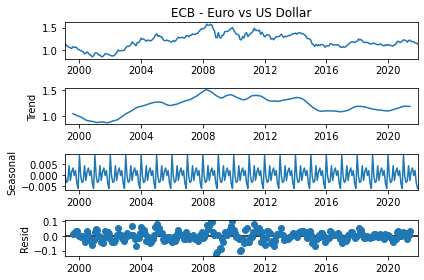

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataframe["ECB - Euro vs US Dollar"].asfreq("D").ffill().asfreq("M"), model='additive')
result.plot()
plt.show()